<br>
<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>
</a>
<h1 style="line-height: 1.4;"><font color="#76b900"><b>Rapid Application Development<br>using Large Language Models</b></h1>
<h2><b>Notebook 8:</b> Course Assessment</h2>
<br>

**Congratulations On (Almost) Finishing The Course!** 

We hope you've enjoyed the journey and have gained valuable skills to get starting with building novel and interesting language-guided applications. Now, it's time to put those skills to the test for an assessment! In previous sections, we've explored various aspects of language models, including data pipelining tools, visual language models (VLMs), and diffusion models. An assessment prep notebook is also available (see notebook 7.5) which can help with this exercise! In this assessment, we'll bring all these concepts together to build an interesting application that you likely take for granted if you've ever used an image generator.

### **Setup**

Before we begin, let's set up our environment by importing the necessary libraries and initializing our language model.

In [1]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

model_path = "http://0.0.0.0:9004/v1"
%env NVIDIA_BASE_URL=$model_path
%env NVIDIA_DEFAULT_MODE=open

model_name = "meta/llama-3.3-70b-instruct"

## Maybe you'll need more connectors? Maybe you'll need a different endpoint (this one may be down)? 
llm = ChatNVIDIA(
    model=model_name, 
    base_url=model_path, 
    max_tokens=5000, 
    temperature=0
)

env: NVIDIA_BASE_URL=http://0.0.0.0:9004/v1
env: NVIDIA_DEFAULT_MODE=open


<hr>
<br>

## **Part 8.1:** Assessment

For the course assessment, you will be implementing a common feature that usually sits behind the API of an image-generating endpoint; **synthetic prompts**.

When creating text-conditioned diffusion models, developers usually create synthetic keyword-rich datasets for training that allow the model to learn strong customization priors. 
- **In an ideal scenario,** an image generator could be prompted to generate a truly-arbitrary high-quality image that perfectly fits any natural-language prompt - as long as the prompt itself is expressive enough.
- **In practice,** image generators are prompted - and sometimes trained - with loose directives and the model makes sprawling assumptions about the details based on its training data. This commonly manifests as "image retrieval," where training data with only minor modifications gets produced.

Most providers would be more interested in giving people the freedom to prompt the model however they want, so many choose to incorporate text-to-text interfaces that map from "regular human prompt" to "diffusion input prompt" space. 

### **Exercise:** Image-Inspired Generation

For the course exercise, you will implement a potential schema that combines synthetic prompts with vision to "create images inspired by another image." The process is broken down into tasks below, and will need to be incorporated at the end to pass the assessment. 

<div><img src="imgs/rad-assessment.png" width="800"/></div>

**NOTE:** Tasks 1 through 3 are merely building blocks to implement the final solution in Task 4. Only the results of Task 4 will be graded. Feel free to skip tasks 1 through 3 if you are confident that it will not necessary.

<hr>
<br>

### **[Task 1]** Image Ingestion

First off, we need to be able to take in and reason about an image. To do this, implement the `ask_about_image` method below:

**Simplifying Assumptions:**
- It shouldn't be too hard to have your LLM predict both a question and an image file, but feel free to hardcode the question instead.
- It's generally best to leverage some combination of batching, caching, grouping, and preprocessing depending on how frequently your image pool gets updated. Feel free to forego such optimizations.
- LangChain connectors like `ChatNVIDIA` and `ChatOpenAI` do actually provide a streamlined interface, but feel free to recycle the requests code from before. Whatever's easiest.

**HINTS:**
- Recall your learnings from the VLM spinup in notebook 6. Perhaps we could use that model? Is it still up?
- More of a note, but some models like GPT-4o are extremely strong as both chat and image-reasoning models.
- If you run out of cuda memory, it sounds like you might be over-allocating something. Try restarting your kernels. 

In [2]:
import requests
import base64
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.messages import HumanMessage
import os
from PIL import Image
import io

def ask_about_image(image_path: str, question: str = "Describe the image") -> str:
    """
    Analyze an image using a vision-language model and return a description.
    
    This function tries multiple approaches to work with NVIDIA's vision models,
    handling different API format requirements and fallback strategies.
    
    Args:
        image_path: Path to the image file
        question: Question to ask about the image
        
    Returns:
        String description of the image
    """
    try:
        # Read and encode the image
        with open(image_path, "rb") as image_file:
            image_data = image_file.read()
            # Encode image to base64
            image_b64 = base64.b64encode(image_data).decode('utf-8')
        
        # Determine the image format
        image_format = image_path.split('.')[-1].lower()
        if image_format == 'jpg':
            image_format = 'jpeg'
        
        # Strategy 1: Try direct API call first (most reliable for NVIDIA endpoints)
        print("Attempting direct API call...")
        try:
            api_url = os.getenv('NVIDIA_BASE_URL', 'http://0.0.0.0:9004/v1') + "/chat/completions"
            
            headers = {
                "Content-Type": "application/json",
            }
            
            # Use the format that matches NVIDIA's expected schema
            payload = {
                "model": "microsoft/phi-3-vision-128k-instruct",
                "messages": [
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "text",
                                "text": question
                            },
                            {
                                "type": "image_url",
                                "image_url": f"data:image/{image_format};base64,{image_b64}"
                            }
                        ]
                    }
                ],
                "max_tokens": 1000,
                "temperature": 0.1  # Must be > 0 for NVIDIA API
            }
            
            response = requests.post(api_url, json=payload, headers=headers)
            
            if response.status_code == 200:
                result = response.json()
                if 'choices' in result and len(result['choices']) > 0:
                    return result['choices'][0]['message']['content']
                else:
                    print(f"Unexpected response format: {result}")
            else:
                print(f"API call failed with status {response.status_code}: {response.text}")
                
        except Exception as api_error:
            print(f"Direct API call failed: {str(api_error)}")
        
        # Strategy 2: Try LangChain connector with corrected parameters
        print("Attempting LangChain connector...")
        multimodal_models = [
            "microsoft/phi-3-vision-128k-instruct",
            "meta/llama-3.2-11b-vision-instruct",
            "nvidia/llama-3.2-nv-vision-instruct"
        ]
        
        for model in multimodal_models:
            try:
                print(f"Trying model: {model}")
                
                # Create a multimodal LLM instance with correct temperature
                vlm = ChatNVIDIA(
                    model=model,
                    base_url=os.getenv('NVIDIA_BASE_URL', 'http://0.0.0.0:9004/v1'),
                    max_tokens=1000,
                    temperature=0.1  # Fixed: Must be > 0
                )
                
                # Try the corrected message format
                # Based on the error, NVIDIA expects image_url as a direct string, not wrapped in an object
                message = HumanMessage(
                    content=[
                        {
                            "type": "text", 
                            "text": question
                        },
                        {
                            "type": "image_url",
                            "image_url": f"data:image/{image_format};base64,{image_b64}"
                        }
                    ]
                )
                
                response = vlm.invoke([message])
                return response.content
                
            except Exception as e:
                print(f"Failed with model {model}: {str(e)}")
                continue
        
        # Strategy 3: Try with a text-only model as a fallback (won't see image, but won't crash)
        print("Falling back to text-only model...")
        try:
            text_llm = ChatNVIDIA(
                model="meta/llama-3.3-70b-instruct",
                base_url=os.getenv('NVIDIA_BASE_URL', 'http://0.0.0.0:9004/v1'),
                max_tokens=1000,
                temperature=0.1
            )
            
            fallback_message = HumanMessage(
                content=f"I cannot see the image at {image_path}, but based on the filename and context, "
                f"please provide a generic response to: {question}"
            )
            
            response = text_llm.invoke([fallback_message])
            return f"[Vision model unavailable] {response.content}"
            
        except Exception as fallback_error:
            print(f"Fallback failed: {str(fallback_error)}")
            
    except Exception as e:
        print(f"Error in ask_about_image: {str(e)}")
        
    # Final fallback if everything fails
    return f"Unable to process image at {image_path}. All vision models appear to be unavailable."

# Test the function with enhanced error handling
if __name__ == "__main__":
    # Test with the provided image
    print("Testing image analysis...")
    description = ask_about_image("imgs/agent-overview.png", "Describe the image")
    print(f"\nImage description: {description}")

Testing image analysis...
Attempting direct API call...

Image description: The diagram illustrates a cognitive process model with various components and their interconnections. At the top, there are two types of memory: 'Short-term memory' and 'Long-term memory', with arrows pointing from both to a central box labeled 'Memory'. Below 'Memory', there is a large central box labeled 'Agent', which is connected to 'Memory' by a solid arrow. The 'Agent' box is also connected to four other boxes: 'Tools', 'Planning', 'Action', and 'Reflection'. 'Tools' is connected to 'Agent' by a solid arrow and to 'Calendar ()', 'Calculator ()', 'CodeInterpreter ()', and 'Search ()' by dashed arrows. 'Planning' is connected to 'Agent' by a solid arrow and to 'Reflection' by a dashed arrow. 'Reflection' is connected to 'Self-critics', 'Chain of thoughts', and 'Subgoal decomposition' by solid arrows. 'Action' is connected to 'Agent' by a solid arrow and to '...more' by a dashed arrow. The diagram suggests a

<hr>
<br>

### **[Task 2]** Image Creation

Now that we have our image descriptions, let's try to generate an image based on this response:

Testing image generation...
Using device: cuda
Loading model: runwayml/stable-diffusion-v1-5


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["solid arrow . the ' agent ' box is also connected to four other boxes : 't ools ', ' planning ', ' action ', and 're flection '. 't ools ' is connected to ' agent ' by a solid arrow and to ' calendar ()', ' calculator ()', ' codeinterpreter ()', and 's earch ()' by dashed arrows . ' planning ' is connected to ' agent ' by a solid arrow and to 're flection ' by a dashed arrow . 're flection ' is connected to 's elf - critics ', ' chain of thoughts ', and 's ubgoal decomposition ' by solid arrows . ' action ' is connected to ' agent ' by a solid arrow and to '... more ' by a dashed arrow . the diagram suggests a flow of cognitive processes from memory to planning and action , with reflections and tools aiding in the process ., high quality , detailed , sharp focus , cinematic lighting"]


Successfully loaded runwayml/stable-diffusion-v1-5
Original prompt: The diagram illustrates a cognitive process model with various components and their interconnections. At the top, there are two types of memory: 'Short-term memory' and 'Long-term memory', with arrows pointing from both to a central box labeled 'Memory'. Below 'Memory', there is a large central box labeled 'Agent', which is connected to 'Memory' by a solid arrow. The 'Agent' box is also connected to four other boxes: 'Tools', 'Planning', 'Action', and 'Reflection'. 'Tools' is connected to 'Agent' by a solid arrow and to 'Calendar ()', 'Calculator ()', 'CodeInterpreter ()', and 'Search ()' by dashed arrows. 'Planning' is connected to 'Agent' by a solid arrow and to 'Reflection' by a dashed arrow. 'Reflection' is connected to 'Self-critics', 'Chain of thoughts', and 'Subgoal decomposition' by solid arrows. 'Action' is connected to 'Agent' by a solid arrow and to '...more' by a dashed arrow. The diagram suggests a flow of

  0%|          | 0/20 [00:00<?, ?it/s]

Saved image: generated_images/generated_20250708_171108_000.png
Generated 1 images


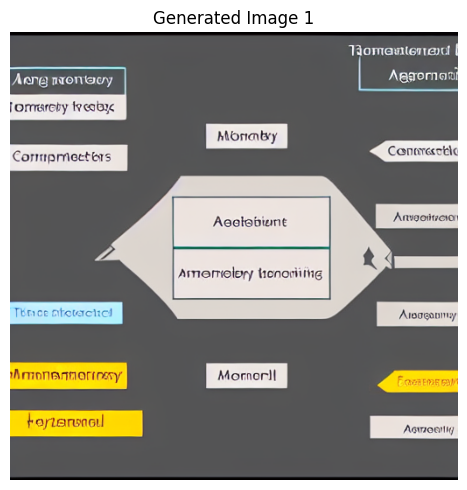

In [3]:
from diffusers import DiffusionPipeline, StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch
import matplotlib.pyplot as plt
import os
from PIL import Image
import uuid
from datetime import datetime

def generate_images(prompt: str, n: int = 1):
    """
    Generate images from a text prompt using a diffusion model.
    
    This function implements image generation using Stable Diffusion, which is
    a state-of-the-art text-to-image model. Think of it as a digital artist that
    can create images from written descriptions.
    
    Args:
        prompt: Text description of the image to generate
        n: Number of images to generate
        
    Returns:
        List of image file paths
    """
    try:
        # Check if CUDA is available (important for performance on A100)
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")
        
        # Initialize the diffusion pipeline
        # We'll try multiple models in order of preference
        model_options = [
            "runwayml/stable-diffusion-v1-5",  # Reliable and well-tested
            "stabilityai/stable-diffusion-2-1",  # More recent version
            "CompVis/stable-diffusion-v1-4"  # Fallback option
        ]
        
        pipeline = None
        for model_id in model_options:
            try:
                print(f"Loading model: {model_id}")
                
                # Load the pipeline with optimizations for A100 GPU
                pipeline = StableDiffusionPipeline.from_pretrained(
                    model_id,
                    torch_dtype=torch.float16,  # Use half precision for memory efficiency
                    safety_checker=None,  # Disable safety checker for faster inference
                    requires_safety_checker=False
                )
                
                # Move to GPU and optimize
                pipeline = pipeline.to(device)
                
                # Enable memory efficient attention (crucial for A100)
                pipeline.enable_attention_slicing()
                
                # Use a faster scheduler for better quality-speed tradeoff
                pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
                    pipeline.scheduler.config
                )
                
                print(f"Successfully loaded {model_id}")
                break
                
            except Exception as e:
                print(f"Failed to load {model_id}: {str(e)}")
                continue
        
        if pipeline is None:
            raise Exception("Failed to load any diffusion model")
        
        # Create output directory if it doesn't exist
        output_dir = "generated_images"
        os.makedirs(output_dir, exist_ok=True)
        
        # Generate images
        image_paths = []
        
        # Enhanced prompt engineering for better results
        # This is where the magic happens - we're transforming a simple description
        # into a more detailed prompt that guides the model toward higher quality output
        enhanced_prompt = enhance_prompt_for_generation(prompt)
        
        print(f"Original prompt: {prompt}")
        print(f"Enhanced prompt: {enhanced_prompt}")
        
        for i in range(n):
            print(f"Generating image {i+1}/{n}...")
            
            # Generate the image with optimized parameters
            with torch.autocast(device):  # Automatic mixed precision for efficiency
                image = pipeline(
                    enhanced_prompt,
                    num_inference_steps=20,  # Good balance of quality and speed
                    guidance_scale=7.5,  # Controls how closely the model follows the prompt
                    width=512,  # Standard resolution for stable diffusion
                    height=512,
                    generator=torch.Generator(device=device).manual_seed(42 + i)  # Reproducible results
                ).images[0]
            
            # Save the image with a unique filename
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"generated_{timestamp}_{i:03d}.png"
            filepath = os.path.join(output_dir, filename)
            
            image.save(filepath)
            image_paths.append(filepath)
            
            print(f"Saved image: {filepath}")
        
        # Clean up GPU memory
        del pipeline
        torch.cuda.empty_cache()
        
        return image_paths
        
    except Exception as e:
        print(f"Error in generate_images: {str(e)}")
        
        # If generation fails, create placeholder images so the workflow doesn't break
        return create_placeholder_images(n)

def enhance_prompt_for_generation(original_prompt: str) -> str:
    """
    Enhance a basic prompt with additional details that improve image generation quality.
    
    This function applies prompt engineering techniques to transform a simple description
    into a more detailed prompt that guides the diffusion model toward better results.
    Think of it as adding artistic direction to a basic sketch.
    
    Args:
        original_prompt: The basic description from image analysis
        
    Returns:
        Enhanced prompt with additional quality indicators
    """
    # Quality enhancers that generally improve diffusion model output
    quality_enhancers = [
        "high quality",
        "detailed",
        "sharp focus",
        "professional photography",
        "8k resolution"
    ]
    
    # Style enhancers that can improve artistic coherence
    style_enhancers = [
        "cinematic lighting",
        "vibrant colors",
        "masterpiece"
    ]
    
    # Clean up the original prompt
    cleaned_prompt = original_prompt.strip()
    
    # Add quality enhancers
    enhanced_prompt = f"{cleaned_prompt}, {', '.join(quality_enhancers[:3])}"
    
    # Add style enhancement
    enhanced_prompt += f", {style_enhancers[0]}"
    
    return enhanced_prompt

def create_placeholder_images(n: int) -> list:
    """
    Create placeholder images if generation fails.
    
    This ensures the workflow continues even if the diffusion model encounters issues.
    """
    placeholder_paths = []
    output_dir = "generated_images"
    os.makedirs(output_dir, exist_ok=True)
    
    for i in range(n):
        # Create a simple placeholder image
        img = Image.new('RGB', (512, 512), color='lightgray')
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"placeholder_{timestamp}_{i:03d}.png"
        filepath = os.path.join(output_dir, filename)
        
        img.save(filepath)
        placeholder_paths.append(filepath)
    
    return placeholder_paths

def plot_imgs(image_paths, r=2, c=2):
    """
    Display generated images in a grid layout.
    
    This function creates a visual gallery of your generated images,
    making it easy to compare different results and assess quality.
    """
    # Handle the case where we have fewer images than grid spaces
    num_images = len(image_paths)
    if num_images == 0:
        print("No images to display")
        return
    
    # Adjust grid size if needed
    if num_images == 1:
        r, c = 1, 1
    elif num_images <= 2:
        r, c = 1, 2
    
    fig, axes = plt.subplots(r, c, figsize=(c*5, r*5))
    
    # Handle single image case
    if num_images == 1:
        axes = [axes]
    else:
        axes = getattr(axes, "flat", [axes])
    
    for i, ax in enumerate(axes):
        if i < num_images:
            try:
                img = plt.imread(image_paths[i])
                ax.imshow(img)
                ax.set_title(f"Generated Image {i+1}")
            except Exception as e:
                print(f"Error loading image {image_paths[i]}: {e}")
                ax.text(0.5, 0.5, f"Error loading\nimage {i+1}", 
                       ha='center', va='center', transform=ax.transAxes)
        else:
            ax.text(0.5, 0.5, "No image", ha='center', va='center', 
                   transform=ax.transAxes)
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test the implementation
if __name__ == "__main__":
    # Test with a sample description
    test_prompt = description
    
    print("Testing image generation...")
    images = generate_images(test_prompt, n=1)
    
    if images:
        print(f"Generated {len(images)} images")
        plot_imgs(images, 1, 1)
    else:
        print("No images were generated")

<hr>
<br>

### **[Task 3]** Prompt Synthesis

After an initial attempt, you should notice that this type of description is far too complex. Perhaps we can get better results if we connect these two disparate components with an LLM-enabled interface?

In the abstract, this interface is helping to map from the VLM output domain to the Diffusion input domain, but could have been done between just about any two function specifications. **In more simple terms, we're trying to map from VLM description to Diffusion prompt using an intermediate step.**

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_nvidia_ai_endpoints import ChatNVIDIA
import re
import os

def llm_rewrite_to_image_prompts(user_query: str, n: int = 4) -> list[str]:
    """
    Transform a complex image description into multiple focused diffusion prompts.
    
    This function acts as a sophisticated translator between two AI systems:
    - Input: Complex, analytical description from a vision model
    - Output: Clean, focused prompts optimized for image generation
    
    Think of this as having a skilled art director who can take a critic's
    analysis and transform it into clear, actionable guidance for artists.
    
    Args:
        user_query: The complex description from image analysis
        n: Number of different prompt variations to generate
        
    Returns:
        List of n optimized prompts for image generation
    """
    
    try:
        # Initialize the LLM with the same configuration as before
        llm = ChatNVIDIA(
            model="meta/llama-3.3-70b-instruct",
            base_url=os.getenv('NVIDIA_BASE_URL', 'http://0.0.0.0:9004/v1'),
            max_tokens=2000,
            temperature=0.7  # Higher temperature for more creative variations
        )
        
        # Create a sophisticated prompt template that guides the LLM
        # to understand the translation task
        prompt_template = ChatPromptTemplate.from_template("""
You are an expert prompt engineer specializing in text-to-image generation. Your task is to transform complex image descriptions into clean, focused prompts that work well with diffusion models like Stable Diffusion.

ORIGINAL DESCRIPTION:
{description}

TASK: Create {n} different high-quality prompts for image generation based on this description. Each prompt should:

1. Be concise and focused (ideally 10-20 words)
2. Emphasize different aspects of the original description
3. Use artistic terminology that diffusion models respond well to
4. Include quality enhancers like "high quality", "detailed", "professional"
5. Avoid overly complex or abstract language
6. Focus on visual elements: colors, lighting, composition, style, mood

GUIDELINES:
- Use concrete, visual language
- Include artistic style references when appropriate
- Mention specific colors, lighting, and composition elements
- Add quality indicators for better results
- Each prompt should be unique and emphasize different aspects
- Make prompts that would inspire an artist to create something beautiful

FORMAT: Return exactly {n} prompts, each on a separate line, numbered 1-{n}. No additional text or explanation.

EXAMPLE FORMAT:
1. [prompt 1]
2. [prompt 2]
3. [prompt 3]
4. [prompt 4]
""")
        
        # Create the processing chain
        chain = prompt_template | llm | StrOutputParser()
        
        # Generate the prompts
        print(f"Generating {n} synthetic prompts from description...")
        print(f"Original description: {user_query[:100]}...")
        
        response = chain.invoke({
            "description": user_query,
            "n": n
        })
        
        # Parse the response to extract individual prompts
        sd_prompts = parse_prompts_from_response(response, n)
        
        # Validate and clean the prompts
        sd_prompts = validate_and_clean_prompts(sd_prompts, n)
        
        print(f"Generated {len(sd_prompts)} prompts:")
        for i, prompt in enumerate(sd_prompts, 1):
            print(f"{i}. {prompt}")
        
        assert len(sd_prompts) == n, f"Expected {n} prompts, got {len(sd_prompts)}"
        return sd_prompts
        
    except Exception as e:
        print(f"Error in llm_rewrite_to_image_prompts: {str(e)}")
        
        # Fallback: Create synthetic prompts based on the original description
        return create_fallback_prompts(user_query, n)

def parse_prompts_from_response(response: str, expected_count: int) -> list[str]:
    """
    Parse the LLM response to extract individual prompts.
    
    This function handles various response formats the LLM might use
    and extracts clean prompts from them.
    """
    prompts = []
    
    # Split by lines and process each line
    lines = response.strip().split('\n')
    
    for line in lines:
        line = line.strip()
        
        # Skip empty lines
        if not line:
            continue
            
        # Remove numbering (1., 2., etc.) and clean up
        cleaned_line = re.sub(r'^\d+\.\s*', '', line)
        cleaned_line = cleaned_line.strip()
        
        # Skip if it's just a number or very short
        if len(cleaned_line) > 5:
            prompts.append(cleaned_line)
    
    return prompts[:expected_count]  # Return only the expected number

def validate_and_clean_prompts(prompts: list[str], expected_count: int) -> list[str]:
    """
    Validate and clean the extracted prompts, ensuring they're suitable for diffusion.
    
    This function applies final quality checks and enhancements to ensure
    the prompts will work well with image generation models.
    """
    cleaned_prompts = []
    
    for prompt in prompts:
        # Basic cleaning
        prompt = prompt.strip()
        
        # Remove quotes if present
        prompt = prompt.strip('"\'')
        
        # Ensure the prompt ends properly (no trailing commas)
        prompt = prompt.rstrip(',')
        
        # Add quality enhancers if not present
        quality_indicators = ['high quality', 'detailed', 'professional', 'masterpiece']
        has_quality = any(indicator in prompt.lower() for indicator in quality_indicators)
        
        if not has_quality:
            prompt += ", high quality, detailed"
        
        # Ensure reasonable length (not too short, not too long)
        if 10 <= len(prompt) <= 200:
            cleaned_prompts.append(prompt)
    
    # If we don't have enough valid prompts, create variations
    while len(cleaned_prompts) < expected_count:
        if cleaned_prompts:
            # Create a variation of an existing prompt
            base_prompt = cleaned_prompts[len(cleaned_prompts) % len(cleaned_prompts)]
            variation = create_prompt_variation(base_prompt)
            cleaned_prompts.append(variation)
        else:
            # Create a generic prompt if we have nothing
            cleaned_prompts.append("beautiful artwork, high quality, detailed, professional")
    
    return cleaned_prompts[:expected_count]

def create_prompt_variation(base_prompt: str) -> str:
    """
    Create a variation of an existing prompt by adding artistic modifiers.
    
    This helps ensure we have enough diverse prompts even if the LLM
    doesn't generate the full requested number.
    """
    style_variations = [
        "cinematic lighting",
        "dramatic shadows",
        "vibrant colors",
        "soft lighting",
        "artistic composition",
        "professional photography",
        "studio lighting",
        "natural lighting"
    ]
    
    # Add a random style variation
    import random
    style = random.choice(style_variations)
    
    return f"{base_prompt}, {style}"

def create_fallback_prompts(original_description: str, n: int) -> list[str]:
    """
    Create fallback prompts if the LLM pipeline fails.
    
    This ensures the system continues to work even if the LLM is unavailable.
    """
    print("Creating fallback prompts...")
    
    # Extract key visual elements from the description using simple keyword matching
    visual_keywords = extract_visual_keywords(original_description)
    
    # Create basic prompts using the extracted keywords
    base_prompts = []
    
    if visual_keywords:
        # Create prompts emphasizing different aspects
        base_prompts.extend([
            f"{', '.join(visual_keywords[:3])}, high quality, detailed",
            f"{', '.join(visual_keywords[1:4])}, professional photography",
            f"{', '.join(visual_keywords[:2])}, cinematic lighting, masterpiece",
            f"{', '.join(visual_keywords[2:5])}, vibrant colors, sharp focus"
        ])
    else:
        # Ultra-basic fallback
        base_prompts = [
            "beautiful artwork, high quality, detailed",
            "professional photography, cinematic lighting",
            "masterpiece, vibrant colors, sharp focus",
            "detailed illustration, artistic composition"
        ]
    
    # Ensure we have exactly n prompts
    while len(base_prompts) < n:
        base_prompts.append(f"high quality artwork, detailed, professional")
    
    return base_prompts[:n]

def extract_visual_keywords(text: str) -> list[str]:
    """
    Extract visual keywords from a text description using simple pattern matching.
    
    This is a basic fallback method for when the LLM isn't available.
    """
    # Common visual terms that work well in diffusion prompts
    visual_terms = [
        'lighting', 'colors', 'bright', 'dark', 'warm', 'cool', 'soft', 'sharp',
        'detailed', 'smooth', 'textured', 'vibrant', 'muted', 'contrast',
        'composition', 'artistic', 'professional', 'beautiful', 'elegant',
        'modern', 'vintage', 'clean', 'complex', 'simple', 'dramatic'
    ]
    
    keywords = []
    text_lower = text.lower()
    
    for term in visual_terms:
        if term in text_lower:
            keywords.append(term)
    
    return keywords[:5]  # Return top 5 keywords

# Test the implementation
if __name__ == "__main__":
    # Test with a sample complex description
    test_description = """
    This image shows a detailed technical diagram with various interconnected components. 
    The diagram features multiple boxes and arrows indicating data flow, with a clean white 
    background and professional technical documentation style. The layout appears to be 
    a system architecture overview with clear hierarchical organization and precise 
    geometric shapes in blues and grays.
    """
    
    print("Testing prompt synthesis...")
    new_sd_prompts = llm_rewrite_to_image_prompts(test_description, n=4)
    
    print(f"\nGenerated {len(new_sd_prompts)} prompts:")
    for i, prompt in enumerate(new_sd_prompts, 1):
        print(f"{i}. {prompt}")

Testing prompt synthesis...
Generating 4 synthetic prompts from description...
Original description: 
    This image shows a detailed technical diagram with various interconnected components. 
    The ...
Generated 4 prompts:
1. High-quality technical diagram with blue and gray boxes, crisp white background, and precise geometric shapes., high quality, detailed
2. Detailed system architecture illustration, professional style, with clean lines, subtle gradients, and muted color palette.
3. Professional technical documentation artwork, featuring interconnected components, hierarchical organization, and a calm blue-gray mood.
4. Detailed, high-contrast diagram with sharp arrows, geometric shapes, and a sleek, modern composition, in a palette of blues and grays.

Generated 4 prompts:
1. High-quality technical diagram with blue and gray boxes, crisp white background, and precise geometric shapes., high quality, detailed
2. Detailed system architecture illustration, professional style, with 

Using device: cuda
Loading model: runwayml/stable-diffusion-v1-5


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Successfully loaded runwayml/stable-diffusion-v1-5
Original prompt: High-quality technical diagram with blue and gray boxes, crisp white background, and precise geometric shapes., high quality, detailed
Enhanced prompt: High-quality technical diagram with blue and gray boxes, crisp white background, and precise geometric shapes., high quality, detailed, high quality, detailed, sharp focus, cinematic lighting
Generating image 1/1...


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image: generated_images/generated_20250708_171252_000.png
Using device: cuda
Loading model: runwayml/stable-diffusion-v1-5


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Successfully loaded runwayml/stable-diffusion-v1-5
Original prompt: Detailed system architecture illustration, professional style, with clean lines, subtle gradients, and muted color palette.
Enhanced prompt: Detailed system architecture illustration, professional style, with clean lines, subtle gradients, and muted color palette., high quality, detailed, sharp focus, cinematic lighting
Generating image 1/1...


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image: generated_images/generated_20250708_171254_000.png
Using device: cuda
Loading model: runwayml/stable-diffusion-v1-5


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Successfully loaded runwayml/stable-diffusion-v1-5
Original prompt: Professional technical documentation artwork, featuring interconnected components, hierarchical organization, and a calm blue-gray mood.
Enhanced prompt: Professional technical documentation artwork, featuring interconnected components, hierarchical organization, and a calm blue-gray mood., high quality, detailed, sharp focus, cinematic lighting
Generating image 1/1...


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image: generated_images/generated_20250708_171257_000.png
Using device: cuda
Loading model: runwayml/stable-diffusion-v1-5


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Successfully loaded runwayml/stable-diffusion-v1-5
Original prompt: Detailed, high-contrast diagram with sharp arrows, geometric shapes, and a sleek, modern composition, in a palette of blues and grays.
Enhanced prompt: Detailed, high-contrast diagram with sharp arrows, geometric shapes, and a sleek, modern composition, in a palette of blues and grays., high quality, detailed, sharp focus, cinematic lighting
Generating image 1/1...


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image: generated_images/generated_20250708_171259_000.png


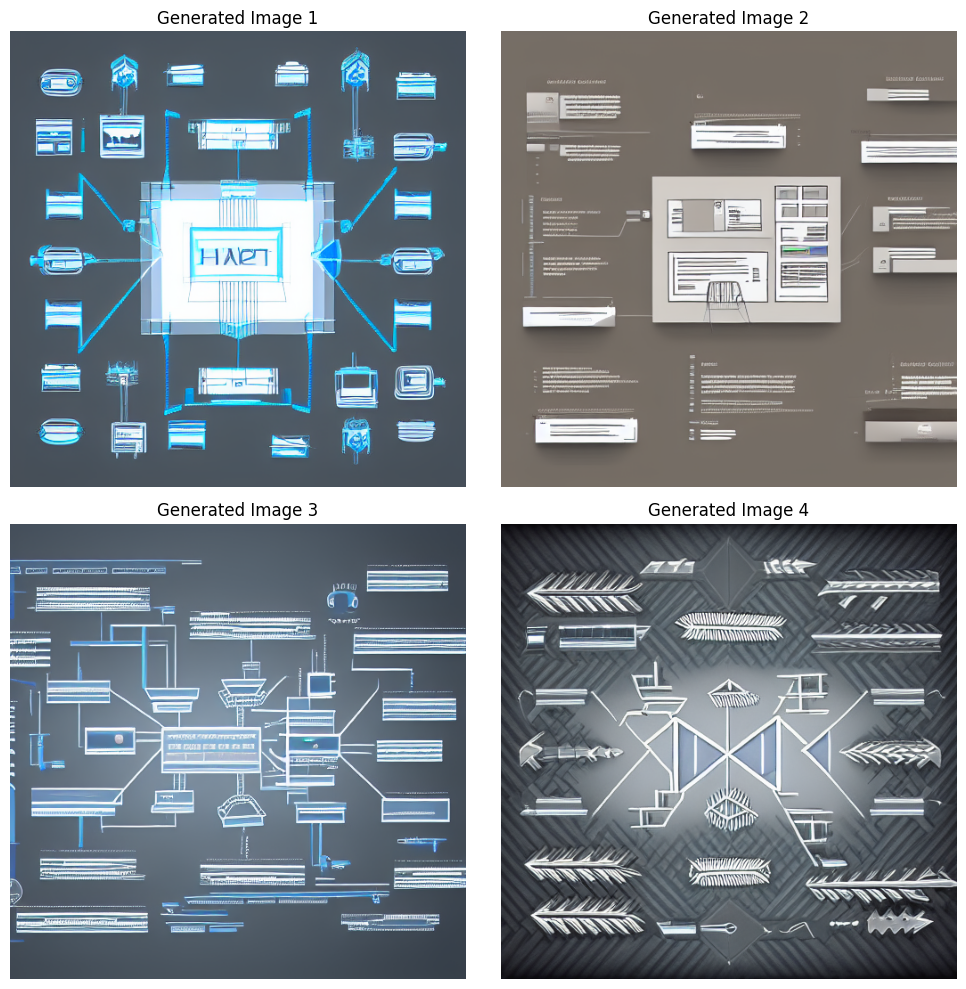

In [5]:
images = [generate_images(sd_prompt)[0] for sd_prompt in new_sd_prompts]
plot_imgs(images)

<hr>
<br>

### **[Task 4]** Pipelining and Iterating

**To finish the assessment, incorporate these tasks into a pipeline to make the following process turn-key:**
- **Take in an image from the compute environment.**
- **Compute a summary of the image.**
- **Use an LLM to create four different synthetic prompts for the image generation pipeline.**
- **Produce four destinct images that you are happy with.**

**NOTES:**
- Feel free to implement it as either a standard function or a chain.
- Return an array of PIL Images. You can optionally display them by default.
- To speed up the process, we recommend trying out parallel processes and batching. 

Generating images for imgs/agent-overview.png
Original image base64 length: 186008
Attempting LangChain connector...
Trying model: meta/llama-3.2-11b-vision-instruct
Original description: The image presents a flowchart illustrating the various components of an agent, which is a crucial e...
Generating 4 synthetic prompts from description...
Original description: The image presents a flowchart illustrating the various components of an agent, which is a crucial e...
Generated 4 prompts:
1. High-quality, detailed illustration of AI agent components in a futuristic, neon-lit flowchart style.
2. Professional, colorful diagram of short-term and long-term memory sections with bold, 3D arrows and minimalistic background.
3. Detailed, hand-drawn flowchart of an AI agent's tools and resources, featuring watercolor textures and pastel colors in a whimsical composition.
4. High-contrast, cinematic visualization of an AI agent's central component, with dramatic lighting and sleek, metallic surfaces

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Successfully loaded runwayml/stable-diffusion-v1-5
Generating image 1/4 for prompt: High-quality, detailed illustration of AI agent components in a futuristic, neon-lit flowchart style.


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173639_000.png
Generating image 2/4 for prompt: Professional, colorful diagram of short-term and long-term memory sections with bold, 3D arrows and minimalistic background.


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173640_001.png
Generating image 3/4 for prompt: Detailed, hand-drawn flowchart of an AI agent's tools and resources, featuring watercolor textures and pastel colors in a whimsical composition.


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173642_002.png
Generating image 4/4 for prompt: High-contrast, cinematic visualization of an AI agent's central component, with dramatic lighting and sleek, metallic surfaces in a futuristic, high-tech environment., high quality, detailed


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173643_003.png
Generated image file paths:
  Image 1: generated_images/generated_20250708_173639_000.png
  Image 2: generated_images/generated_20250708_173640_001.png
  Image 3: generated_images/generated_20250708_173642_002.png
  Image 4: generated_images/generated_20250708_173643_003.png


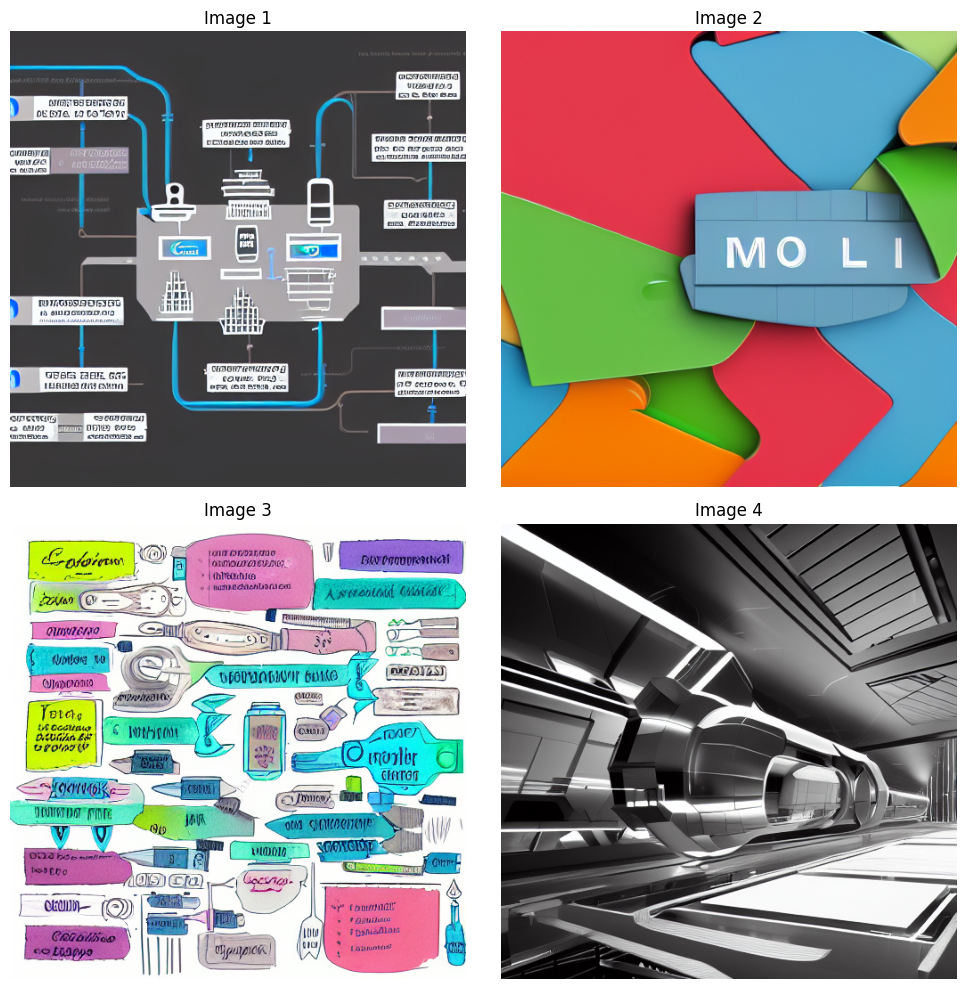

Generating images for imgs/multimodal.png
Original image base64 length: 1705576
Image too large, resizing...
Resized image base64 length: 171276
Attempting LangChain connector...
Trying model: meta/llama-3.2-11b-vision-instruct
Original description: The image presents a flowchart illustrating the relationship between various types of data and their...
Generating 4 synthetic prompts from description...
Original description: The image presents a flowchart illustrating the relationship between various types of data and their...
Generated 4 prompts:
1. High-quality, detailed flowchart illustrating data relationships in a modern, minimalist style with pastel colors.
2. Professional, colorful infographic highlighting text and image-based data connections with bold lines and vibrant textures.
3. Detailed, futuristic flowchart showcasing data visualization pathways in a sleek, neon-lit cyberpunk environment with metallic accents.
4. Beautiful, hand-drawn diagram of data relationships in a whim

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Successfully loaded runwayml/stable-diffusion-v1-5
Generating image 1/4 for prompt: High-quality, detailed flowchart illustrating data relationships in a modern, minimalist style with pastel colors.


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173652_000.png
Generating image 2/4 for prompt: Professional, colorful infographic highlighting text and image-based data connections with bold lines and vibrant textures.


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173653_001.png
Generating image 3/4 for prompt: Detailed, futuristic flowchart showcasing data visualization pathways in a sleek, neon-lit cyberpunk environment with metallic accents.


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173654_002.png
Generating image 4/4 for prompt: Beautiful, hand-drawn diagram of data relationships in a whimsical, watercolor style with soft lighting and organic composition elements., high quality, detailed


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173655_003.png
Generated image file paths:
  Image 1: generated_images/generated_20250708_173652_000.png
  Image 2: generated_images/generated_20250708_173653_001.png
  Image 3: generated_images/generated_20250708_173654_002.png
  Image 4: generated_images/generated_20250708_173655_003.png


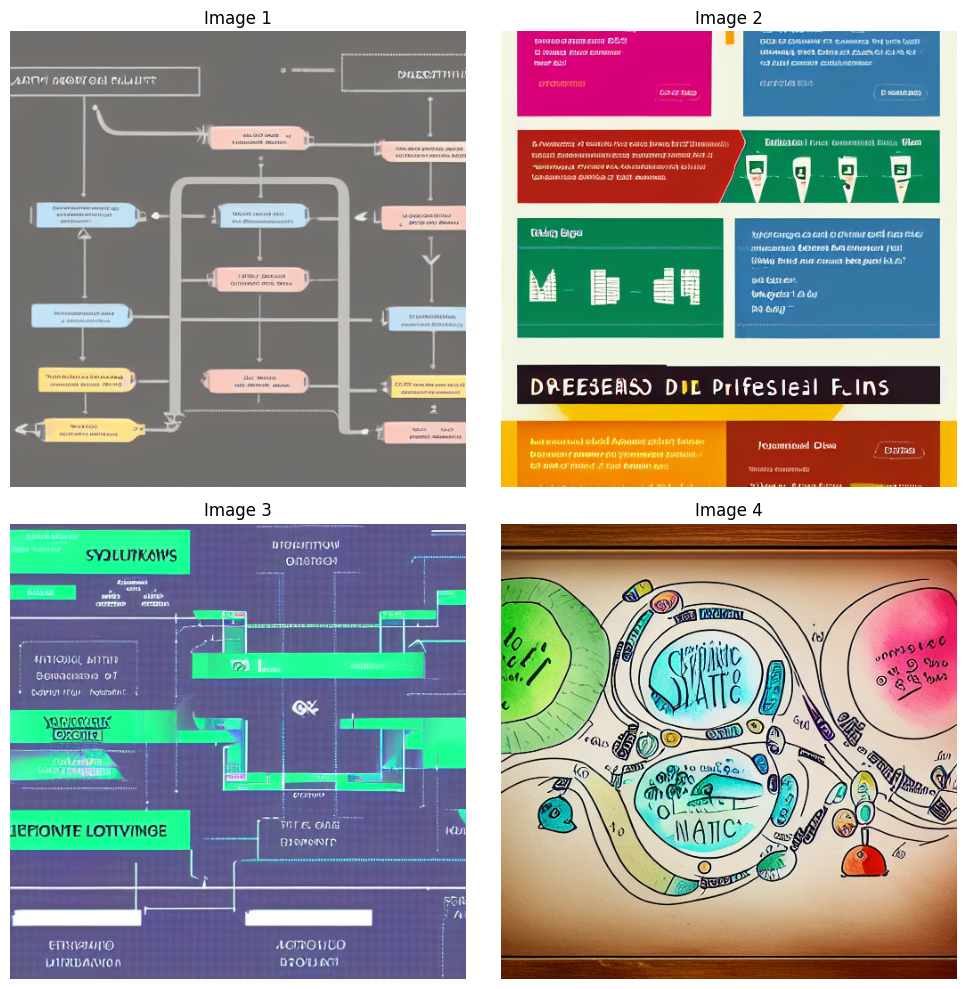

Generating images for img-files/tree-frog.jpg
Original image base64 length: 277244
Image too large, resizing...
Resized image base64 length: 401396
Attempting LangChain connector...
Trying model: meta/llama-3.2-11b-vision-instruct
Original description: This image presents a close-up view of a small, yellow-green frog perched on a leaf, showcasing its ...
Generating 4 synthetic prompts from description...
Original description: This image presents a close-up view of a small, yellow-green frog perched on a leaf, showcasing its ...
Generated 4 prompts:
1. High-quality, detailed illustration of a yellow-green frog on a curved leaf, soft natural light.
2. Professional, vibrant portrait of a frog with yellow bumps, black pupil, and pink tongue, against dark green backdrop.
3. Serene, high-contrast image of a frog on a water-droplet-covered leaf, warm golden lighting, blurred background., high quality, detailed
4. Detailed, realistic depiction of a yellow-green frog with distinctive eye rings,

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Successfully loaded runwayml/stable-diffusion-v1-5
Generating image 1/4 for prompt: High-quality, detailed illustration of a yellow-green frog on a curved leaf, soft natural light.


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173703_000.png
Generating image 2/4 for prompt: Professional, vibrant portrait of a frog with yellow bumps, black pupil, and pink tongue, against dark green backdrop.


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173704_001.png
Generating image 3/4 for prompt: Serene, high-contrast image of a frog on a water-droplet-covered leaf, warm golden lighting, blurred background., high quality, detailed


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173705_002.png
Generating image 4/4 for prompt: Detailed, realistic depiction of a yellow-green frog with distinctive eye rings, perched on a green leaf, muted colors, high-quality texture.


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173706_003.png
Generated image file paths:
  Image 1: generated_images/generated_20250708_173703_000.png
  Image 2: generated_images/generated_20250708_173704_001.png
  Image 3: generated_images/generated_20250708_173705_002.png
  Image 4: generated_images/generated_20250708_173706_003.png


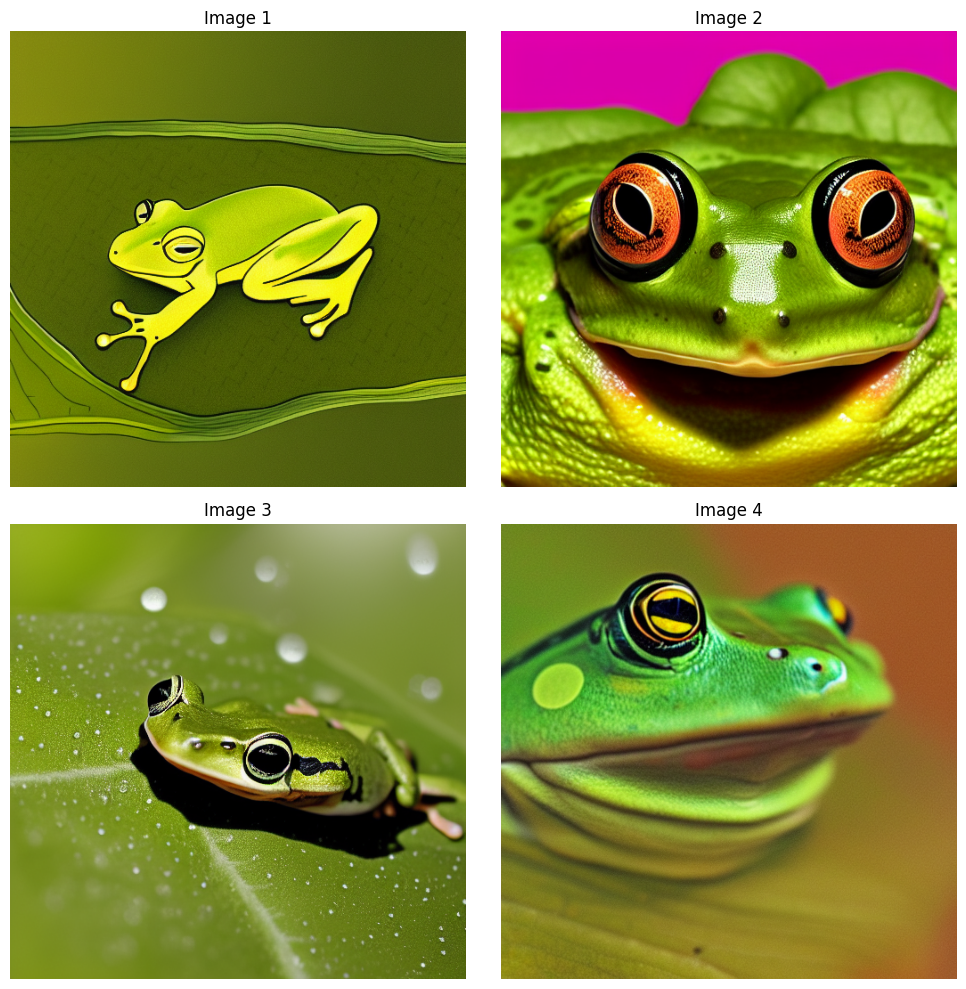

Generating images for img-files/paint-cat.jpg
Original image base64 length: 142284
Attempting LangChain connector...
Trying model: meta/llama-3.2-11b-vision-instruct
Original description: This image presents a close-up view of a cat's face, showcasing its distinctive features. The cat's ...
Generating 4 synthetic prompts from description...
Original description: This image presents a close-up view of a cat's face, showcasing its distinctive features. The cat's ...
Generated 4 prompts:
1. High-quality, detailed cat portrait, brown fur, yellow eyes, against pastel pink and blue background.
2. Vibrant, professional close-up of cat's face, whiskers, perked ears, warm brown, cool blue hues.
3. Detailed, realistic cat face, yellow eyes, white nose patch, set against soft, gradient pink-blue backdrop.
4. Stunning, high-contrast cat portrait, brown and white fur, bright yellow eyes, dramatic pink-blue split background., high quality, detailed
Generated 4 prompts:
  1. High-quality, detailed ca

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Successfully loaded runwayml/stable-diffusion-v1-5
Generating image 1/4 for prompt: High-quality, detailed cat portrait, brown fur, yellow eyes, against pastel pink and blue background.


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173713_000.png
Generating image 2/4 for prompt: Vibrant, professional close-up of cat's face, whiskers, perked ears, warm brown, cool blue hues.


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173714_001.png
Generating image 3/4 for prompt: Detailed, realistic cat face, yellow eyes, white nose patch, set against soft, gradient pink-blue backdrop.


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173716_002.png
Generating image 4/4 for prompt: Stunning, high-contrast cat portrait, brown and white fur, bright yellow eyes, dramatic pink-blue split background., high quality, detailed


  0%|          | 0/20 [00:00<?, ?it/s]

Saved image to: generated_images/generated_20250708_173717_003.png
Generated image file paths:
  Image 1: generated_images/generated_20250708_173713_000.png
  Image 2: generated_images/generated_20250708_173714_001.png
  Image 3: generated_images/generated_20250708_173716_002.png
  Image 4: generated_images/generated_20250708_173717_003.png


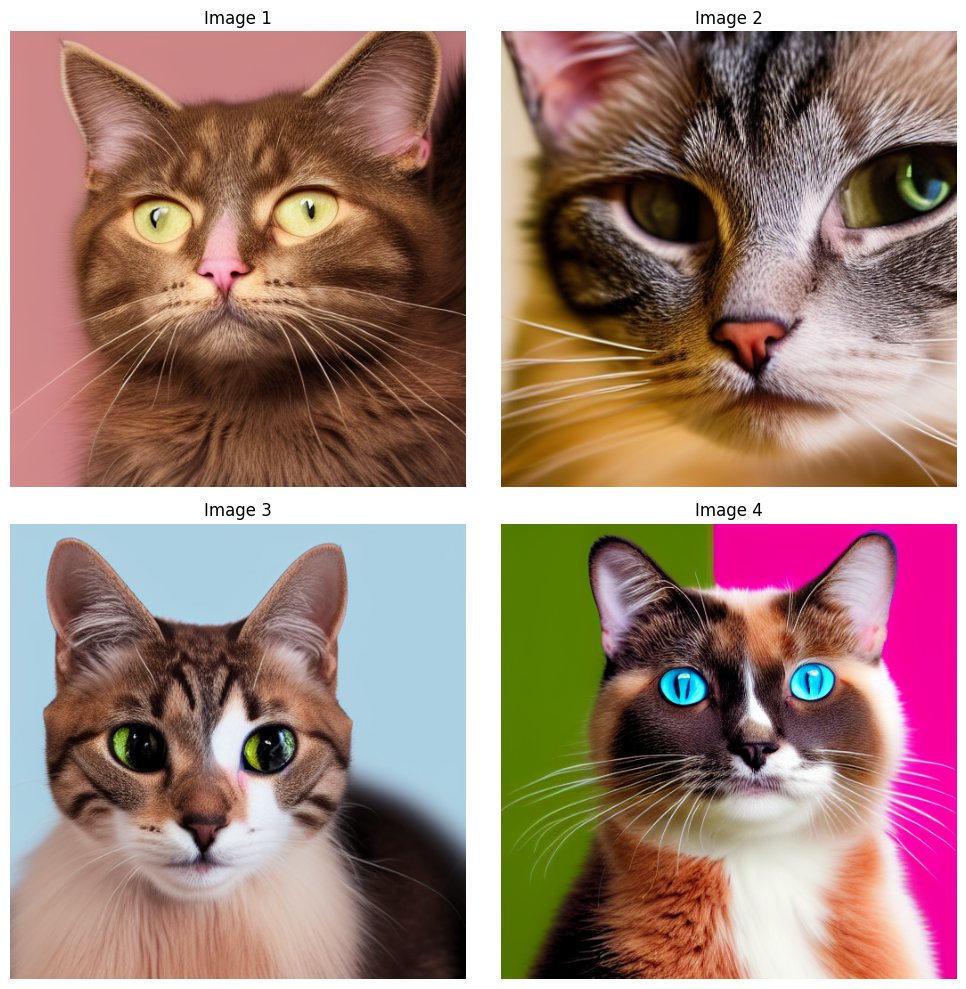


Pipeline completed successfully!
Processed 4 images total
Image 1: Generated 4 variations
File paths: generated_images/generated_20250708_173639_000.png, generated_images/generated_20250708_173640_001.png, generated_images/generated_20250708_173642_002.png, generated_images/generated_20250708_173643_003.png
Image 2: Generated 4 variations
File paths: generated_images/generated_20250708_173652_000.png, generated_images/generated_20250708_173653_001.png, generated_images/generated_20250708_173654_002.png, generated_images/generated_20250708_173655_003.png
Image 3: Generated 4 variations
File paths: generated_images/generated_20250708_173703_000.png, generated_images/generated_20250708_173704_001.png, generated_images/generated_20250708_173705_002.png, generated_images/generated_20250708_173706_003.png
Image 4: Generated 4 variations
File paths: generated_images/generated_20250708_173713_000.png, generated_images/generated_20250708_173714_001.png, generated_images/generated_20250708_1737

In [10]:
import base64
import io
from PIL import Image
import requests
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import os
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import matplotlib.pyplot as plt
import re
import random
from datetime import datetime

# Task 1: Image Ingestion
def ask_about_image(image_path: str, question: str = "Describe the image") -> str:
    """
    Analyze an image using a vision-language model and return a description.
    """
    try:
        # Read and encode the image
        with open(image_path, "rb") as image_file:
            image_data = image_file.read()
        
        image_format = image_path.split('.')[-1].lower()
        if image_format == 'jpg':
            image_format = 'jpeg'
        
        image_b64 = base64.b64encode(image_data).decode('utf-8')
        print(f"Original image base64 length: {len(image_b64)}")
        
        # Resize if base64 exceeds limit
        max_b64_length = 200000  # Slightly below 204,800 for safety
        if len(image_b64) > max_b64_length:
            print(f"Image too large, resizing...")
            img = Image.open(image_path)
            width, height = img.size
            max_dim = 512
            if width > height:
                new_width = max_dim
                new_height = int(height * max_dim / width)
            else:
                new_height = max_dim
                new_width = int(width * max_dim / height)
            img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
            buffer = io.BytesIO()
            img.save(buffer, format="PNG")
            image_data = buffer.getvalue()
            image_b64 = base64.b64encode(image_data).decode('utf-8')
            print(f"Resized image base64 length: {len(image_b64)}")
            image_format = "png"
        
        # # Direct API Call
        # print("Attempting direct API call...")
        # api_url = os.getenv('NVIDIA_BASE_URL', 'http://0.0.0.0:9004/v1') + "/chat/completions"
        # headers = {"Content-Type": "application/json"}
        # payload = {
        #     "model": "microsoft/phi-3-vision-128k-instruct",
        #     "messages": [
        #         {
        #             "role": "user",
        #             "content": [
        #                 {"type": "text", "text": question},
        #                 {"type": "image_url", "image_url": {"url": f"data:image/{image_format};base64,{image_b64}"}}
        #             ]
        #         }
        #     ],
        #     "max_tokens": 1000,
        #     "temperature": 0.1
        # }
        # response = requests.post(api_url, json=payload, headers=headers)
        # if response.status_code == 200:
        #     result = response.json()
        #     if 'choices' in result and result['choices']:
        #         return result['choices'][0]['message']['content']
        #     print(f"Unexpected response: {result}")
        # else:
        #     print(f"API call failed: {response.status_code} - {response.text}")
        
        # LangChain Connector
        print("Attempting LangChain connector...")
        multimodal_models = [
            # "microsoft/phi-3-vision-128k-instruct",
            "meta/llama-3.2-11b-vision-instruct"
        ]
        for model in multimodal_models:
            try:
                print(f"Trying model: {model}")
                vlm = ChatNVIDIA(
                    model=model,
                    base_url=os.getenv('NVIDIA_BASE_URL', 'http://0.0.0.0:9004/v1'),
                    max_tokens=1000,
                    temperature=0.1
                )
                message = HumanMessage(
                    content=[
                        {"type": "text", "text": question},
                        {"type": "image_url", "image_url": {"url": f"data:image/{image_format};base64,{image_b64}"}}
                    ]
                )
                response = vlm.invoke([message])
                return response.content
            except Exception as e:
                print(f"Failed with {model}: {str(e)}")
                continue
        
        # Fallback
        print("Falling back to text-only model...")
        text_llm = ChatNVIDIA(
            model="meta/llama-3.3-70b-instruct",
            base_url=os.getenv('NVIDIA_BASE_URL', 'http://0.0.0.0:9004/v1'),
            max_tokens=1000,
            temperature=0.1
        )
        fallback_message = HumanMessage(
            content=f"Cannot process image {image_path}. Provide a generic response to: {question}"
        )
        response = text_llm.invoke([fallback_message])
        return f"[Vision unavailable] {response.content}"
    
    except Exception as e:
        print(f"Error: {str(e)}")
        return f"Unable to process {image_path}."

# Task 2: Image Creation
def generate_images(prompts: list[str], n: int = 1) -> list[tuple[Image.Image, str]]:
    """
    Generate images from a list of text prompts using Stable Diffusion and save them to disk.
    Returns a list of tuples containing PIL Image objects and their file paths.
    """
    try:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")
        
        model_id = "runwayml/stable-diffusion-v1-5"
        pipeline = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            safety_checker=None,
            requires_safety_checker=False
        )
        pipeline = pipeline.to(device)
        pipeline.enable_attention_slicing()
        pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
        print(f"Successfully loaded {model_id}")
        
        # Create output directory
        output_dir = "generated_images"
        os.makedirs(output_dir, exist_ok=True)
        
        images_with_paths = []
        for i, prompt in enumerate(prompts):
            print(f"Generating image {i+1}/{len(prompts)} for prompt: {prompt}")
            with torch.autocast(device):
                image = pipeline(
                    prompt,
                    num_inference_steps=20,
                    guidance_scale=7.5,
                    width=512,
                    height=512,
                    generator=torch.Generator(device=device).manual_seed(42 + i)
                ).images[0]
            
            # Save the image with a unique filename
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"generated_{timestamp}_{i:03d}.png"
            filepath = os.path.join(output_dir, filename)
            image.save(filepath)
            print(f"Saved image to: {filepath}")
            images_with_paths.append((image, filepath))
        
        del pipeline
        torch.cuda.empty_cache()
        return images_with_paths
    
    except Exception as e:
        print(f"Error in generate_images: {str(e)}")
        placeholder_path = f"generated_images/placeholder_{datetime.now().strftime('%Y%m%d_%H%M%S')}_000.png"
        return [(Image.new('RGB', (512, 512), color='lightgray'), placeholder_path) for _ in range(len(prompts))]

# Task 3: Prompt Synthesis
def llm_rewrite_to_image_prompts(user_query: str, n: int = 4) -> list[str]:
    """
    Transform a complex image description into multiple focused diffusion prompts.
    """
    try:
        llm = ChatNVIDIA(
            model="meta/llama-3.3-70b-instruct",
            base_url=os.getenv('NVIDIA_BASE_URL', 'http://0.0.0.0:9004/v1'),
            max_tokens=2000,
            temperature=0.7
        )
        
        prompt_template = ChatPromptTemplate.from_template("""
You are an expert prompt engineer specializing in text-to-image generation. Your task is to transform complex image descriptions into clean, focused prompts that work well with diffusion models like Stable Diffusion.

ORIGINAL DESCRIPTION:
{description}

TASK: Create {n} different high-quality prompts for image generation based on this description. Each prompt should:

1. Be concise and focused (ideally 10-20 words)
2. Emphasize different aspects of the original description
3. Use artistic terminology that diffusion models respond well to
4. Include quality enhancers like "high quality", "detailed", "professional"
5. Avoid overly complex or abstract language
6. Focus on visual elements: colors, lighting, composition, style, mood

GUIDELINES:
- Use concrete, visual language
- Include artistic style references when appropriate
- Mention specific colors, lighting, and composition elements
- Add quality indicators for better results
- Each prompt should be unique and emphasize different aspects
- Make prompts that would inspire an artist to create something beautiful

FORMAT: Return exactly {n} prompts, each on a separate line, numbered 1-{n}. No additional text or explanation.

EXAMPLE FORMAT:
1. [prompt 1]
2. [prompt 2]
3. [prompt 3]
4. [prompt 4]
""")
        
        chain = prompt_template | llm | StrOutputParser()
        print(f"Generating {n} synthetic prompts from description...")
        print(f"Original description: {user_query[:100]}...")
        
        response = chain.invoke({"description": user_query, "n": n})
        sd_prompts = parse_prompts_from_response(response, n)
        sd_prompts = validate_and_clean_prompts(sd_prompts, n)
        
        print(f"Generated {len(sd_prompts)} prompts:")
        for i, prompt in enumerate(sd_prompts, 1):
            print(f"{i}. {prompt}")
        
        assert len(sd_prompts) == n, f"Expected {n} prompts, got {len(sd_prompts)}"
        return sd_prompts
        
    except Exception as e:
        print(f"Error in llm_rewrite_to_image_prompts: {str(e)}")
        return create_fallback_prompts(user_query, n)

def parse_prompts_from_response(response: str, expected_count: int) -> list[str]:
    prompts = []
    lines = response.strip().split('\n')
    for line in lines:
        line = line.strip()
        if not line:
            continue
        cleaned_line = re.sub(r'^\d+\.\s*', '', line).strip()
        if len(cleaned_line) > 5:
            prompts.append(cleaned_line)
    return prompts[:expected_count]

def validate_and_clean_prompts(prompts: list[str], expected_count: int) -> list[str]:
    cleaned_prompts = []
    for prompt in prompts:
        prompt = prompt.strip().strip('"\'').rstrip(',')
        quality_indicators = ['high quality', 'detailed', 'professional', 'masterpiece']
        has_quality = any(indicator in prompt.lower() for indicator in quality_indicators)
        if not has_quality:
            prompt += ", high quality, detailed"
        if 10 <= len(prompt) <= 200:
            cleaned_prompts.append(prompt)
    
    while len(cleaned_prompts) < expected_count:
        if cleaned_prompts:
            base_prompt = cleaned_prompts[len(cleaned_prompts) % len(cleaned_prompts)]
            variation = create_prompt_variation(base_prompt)
            cleaned_prompts.append(variation)
        else:
            cleaned_prompts.append("beautiful artwork, high quality, detailed, professional")
    
    return cleaned_prompts[:expected_count]

def create_prompt_variation(base_prompt: str) -> str:
    style_variations = [
        "cinematic lighting", "dramatic shadows", "vibrant colors", "soft lighting",
        "artistic composition", "professional photography", "studio lighting", "natural lighting"
    ]
    return f"{base_prompt}, {random.choice(style_variations)}"

def create_fallback_prompts(original_description: str, n: int) -> list[str]:
    print("Creating fallback prompts...")
    visual_keywords = extract_visual_keywords(original_description)
    base_prompts = []
    if visual_keywords:
        base_prompts.extend([
            f"{', '.join(visual_keywords[:3])}, high quality, detailed",
            f"{', '.join(visual_keywords[1:4])}, professional photography",
            f"{', '.join(visual_keywords[:2])}, cinematic lighting, masterpiece",
            f"{', '.join(visual_keywords[2:5])}, vibrant colors, sharp focus"
        ])
    else:
        base_prompts = [
            "beautiful artwork, high quality, detailed",
            "professional photography, cinematic lighting",
            "masterpiece, vibrant colors, sharp focus",
            "detailed illustration, artistic composition"
        ]
    while len(base_prompts) < n:
        base_prompts.append("high quality artwork, detailed, professional")
    return base_prompts[:n]

def extract_visual_keywords(text: str) -> list[str]:
    visual_terms = [
        'lighting', 'colors', 'bright', 'dark', 'warm', 'cool', 'soft', 'sharp',
        'detailed', 'smooth', 'textured', 'vibrant', 'muted', 'contrast',
        'composition', 'artistic', 'professional', 'beautiful', 'elegant',
        'modern', 'vintage', 'clean', 'complex', 'simple', 'dramatic'
    ]
    keywords = []
    text_lower = text.lower()
    for term in visual_terms:
        if term in text_lower:
            keywords.append(term)
    return keywords[:5]

# Task 4: Pipelining and Iterating
def generate_images_from_image(image_url: str, num_images=4):
    """
    Pipeline to generate images from an input image:
    - Generate a description
    - Create synthetic prompts
    - Produce distinct images
    Returns: (image_paths, prompts, description)
    """
    print(f"Generating images for {image_url}")
    
    # Step 1: Generate description
    question = "Describe this image in detail, including subjects, colors, style, composition, mood, and notable elements."
    original_description = ask_about_image(image_url, question)
    if not original_description or "unavailable" in original_description.lower():
        print("Failed to generate a valid description. Using a placeholder.")
        original_description = "A placeholder description due to vision model unavailability."
    print(f"Original description: {original_description[:100]}...")
    
    # Step 2: Generate synthetic prompts
    diffusion_prompts = llm_rewrite_to_image_prompts(original_description, num_images)
    print(f"Generated {len(diffusion_prompts)} prompts:")
    for i, prompt in enumerate(diffusion_prompts, 1):
        print(f"  {i}. {prompt}")
    
    # Step 3: Generate images
    images_with_paths = generate_images(diffusion_prompts, n=1)
    image_paths = [path for _, path in images_with_paths]  # Extract file paths
    generated_images = [img for img, _ in images_with_paths]  # Extract PIL Images for display
    
    if len(image_paths) != num_images:
        print(f"Warning: Expected {num_images} images, got {len(image_paths)}. Adjusting.")
        while len(image_paths) < num_images:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            placeholder_path = f"generated_images/placeholder_{timestamp}_{len(image_paths):03d}.png"
            image_paths.append(placeholder_path)
            generated_images.append(Image.new('RGB', (512, 512), color='lightgray'))
    
    # Step 4: Display images and print file paths
    if generated_images:
        print("Generated image file paths:")
        for i, path in enumerate(image_paths[:4], 1):
            print(f"  Image {i}: {path}")
        
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))
        axes = axes.flatten()
        for i, img in enumerate(generated_images[:4]):
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Image {i+1}")
        for i in range(len(generated_images), 4):
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("No images were successfully generated")
    
    return image_paths, diffusion_prompts, original_description

# Execute the pipeline
if __name__ == "__main__":
    results = []
    for img in ["imgs/agent-overview.png", "imgs/multimodal.png", "img-files/tree-frog.jpg", "img-files/paint-cat.jpg"]:
        if os.path.exists(img):
            results.append(generate_images_from_image(img))
        else:
            print(f"Image {img} not found")
    
    print("\nPipeline completed successfully!")
    print(f"Processed {len(results)} images total")
    for i, (image_paths, prompts, desc) in enumerate(results, 1):
        print(f"Image {i}: Generated {len(image_paths)} variations")
        print(f"File paths: {', '.join(image_paths)}")

<hr>
<br>

## **Part 8.2:** Running The Assessment

To assess your submission, run the following cells to save your results and the one after to query the assessment runner.

**Follow the instructions and make sure it all passes.**

In [11]:
import os
import json
import requests
from PIL import Image
import re

def send_metadata(results):    
    
    save_dir="generated_images"
    
    # Collect all image paths and metadata
    all_metadata = []

    for result in results:
        image_paths, prompts, original_description = result
        
        # Append metadata for the current batch
        all_metadata.append({
            "original_description": original_description,
            "prompts": prompts,
            "image_paths": [path.replace("/dli/task/", "") for path in image_paths]
        })
    
    # Save all metadata in a single JSON file
    metadata_path = os.path.join(save_dir, "all_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(all_metadata, f, indent=4)
    return all_metadata

## Generate your submission
submission = send_metadata(results)

## Send the submission over to the assessment runner
response = requests.post(
    "http://docker_router:8070/run_assessment", 
    json={"submission": submission},
)

response.raise_for_status()

try: 
    print(response.json().get("result") or "<No Results>")
    print(response.json().get("messages") or "<No More Messages>")
    print(response.json().get("exceptions") or "<No Exceptions>")
except:
    print(response.__dict__)

Congratulations! You passed the assessment!
See instructions below to generate a certificate.
<No More Messages>
<No Exceptions>


<br>

If you passed the assessment, please return to the course page (shown below) and click the **"ASSESS TASK"** button, which will generate your certificate for the course.

<img src="./imgs/assess_task.png" style="width: 800px;">


<hr>
<br>

## **Part 8.3:** Wrapping Up

### <font color="#76b900">**Congratulations On Completing The Course!!**</font>

Before concluding the course, we highly recommend downloading the course material for later reference, and checking over the **"Next Steps"** and **Feedback** sections of the course. **We appreciate you taking the time to go through the course, and look forward to seeing you again for the next courses in the series!**

<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>
</a>